In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import PIL.ImageOps as ImageOps
import PIL.Image as Image
from tqdm import tqdm
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [ ]:
class_names = ['Alpinia Galanga (Rasna)',
                'Amaranthus Viridis (Arive-Dantu)',
               'Artocarpus Heterophyllus (Jackfruit)',
               'Azadirachta Indica (Neem)',
               'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)',
               'Carissa Carandas (Karanda)',
               'Citrus Limon (Lemon)',
               'Ficus Auriculata (Roxburgh fig)',
               'Ficus Religiosa (Peepal Tree)',
               'Hibiscus Rosa-sinensis',
               'Jasminum (Jasmine)',
               'Mangifera Indica (Mango)',
               'Mentha (Mint)',
               'Moringa Oleifera (Drumstick)',
               'Muntingia Calabura (Jamaica Cherry-Gasagase)',
               'Murraya Koenigii (Curry)',
               'Nerium Oleander (Oleander)',
               'Nyctanthes Arbor-tristis (Parijata)',
               'Ocimum Tenuiflorum (Tulsi)',
               'Piper Betle (Betel)',
               'Plectranthus Amboinicus (Mexican Mint)',
               'Pongamia Pinnata (Indian Beech)',
               'Psidium Guajava (Guava)',
               'Punica Granatum (Pomegranate)',
               'Santalum Album (Sandalwood)',
               'Syzygium Cumini (Jamun)',
               'Syzygium Jambos (Rose Apple)',
               'Tabernaemontana Divaricata (Crape Jasmine)',
               'Trigonella Foenum-graecum (Fenugreek)']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
def pre_process(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    return image

In [ ]:
def load_data():
    
    datasets = ["/content/gdrive/MyDrive/POC/PLANT/TRAIN DATA","/content/gdrive/MyDrive/POC/PLANT/TEST DATA"]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = pre_process(img_path) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/gdrive/MyDrive/POC/PLANT/TRAIN DATA


100%|██████████| 98/98 [00:23<00:00,  4.15it/s]


Loading /content/gdrive/MyDrive/POC/PLANT/TEST DATA


100%|██████████| 24/24 [00:06<00:00,  3.75it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1469
Number of testing examples: 367
Each image is of size: (150, 150)


In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [ ]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("EXAMPLES OF IMAGES FROM THE DATASET", fontsize=16)
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]],fontsize=10)
    plt.show()

In [ ]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

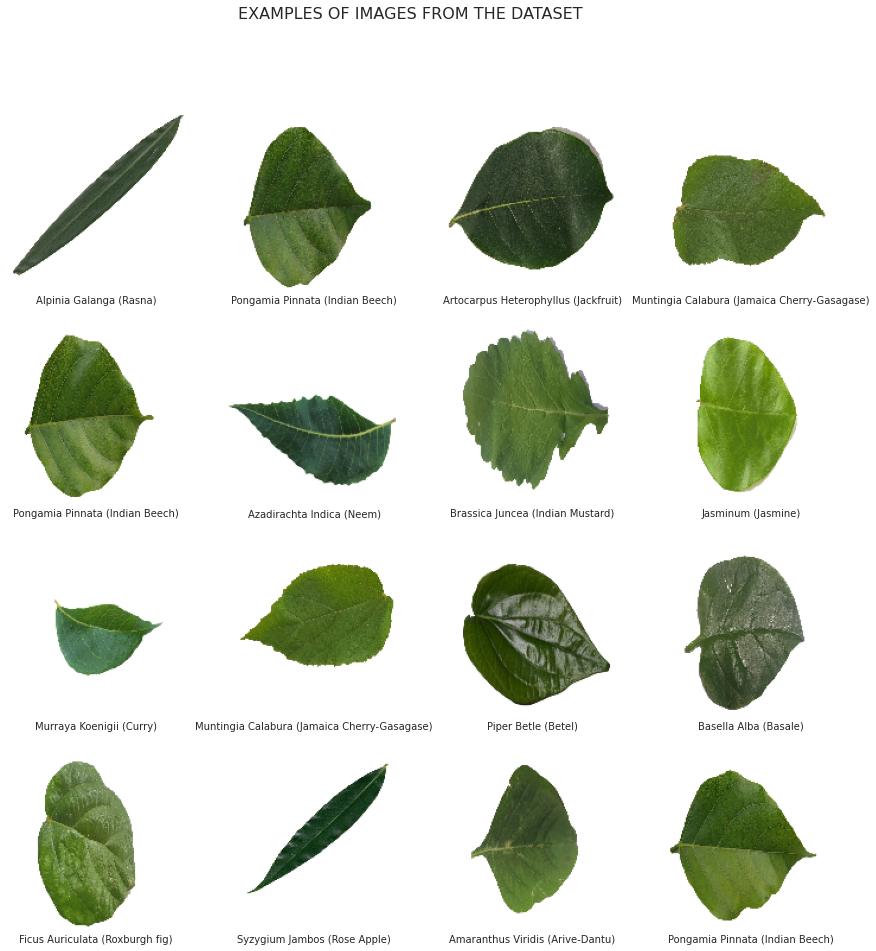

In [ ]:
display_examples(class_names, train_images, train_labels)

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(30, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 31s 3s/step - loss: 3.2558 - accuracy: 0.1038 - val_loss: 2.9387 - val_accuracy: 0.1803
Epoch 2/20
10/10 [==============================] - 27s 3s/step - loss: 2.3671 - accuracy: 0.3702 - val_loss: 2.0172 - val_accuracy: 0.4354
Epoch 3/20
10/10 [==============================] - 27s 3s/step - loss: 1.5570 - accuracy: 0.5591 - val_loss: 1.5047 - val_accuracy: 0.5986
Epoch 4/20
10/10 [==============================] - 27s 3s/step - loss: 1.0527 - accuracy: 0.7106 - val_loss: 1.3099 - val_accuracy: 0.6905
Epoch 5/20
10/10 [==============================] - 27s 3s/step - loss: 0.7193 - accuracy: 0.7643 - val_loss: 1.0889 - val_accuracy: 0.7245
Epoch 6/20
10/10 [==============================] - 28s 3s/step - loss: 0.5247 - accuracy: 0.8460 - val_loss: 0.9923 - val_accuracy: 0.7347
Epoch 7/20
10/10 [==============================] - 27s 3s/step - loss: 0.3711 - accuracy: 0.8843 - val_loss: 1.0024 - val_accuracy: 0.7449
Epoch 8/20
10/10 [=============

In [ ]:
def plot_accuracy_loss(history):
    """
        We plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

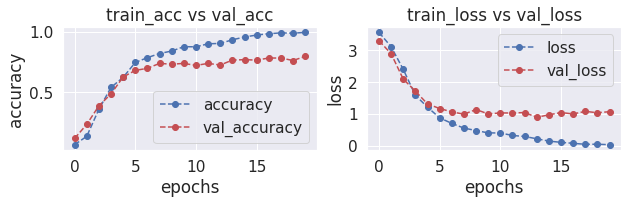

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

12/12 [==============================] - 2s 190ms/step - loss: 1.5148 - accuracy: 0.6866


12/12 [==============================] - 2s 189ms/step


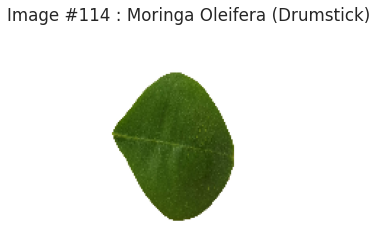

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [ ]:
data = np.ndarray(shape=(1, 150, 150, 3), dtype=np.float32)
image = Image.open('/content/gdrive/MyDrive/POC/PLANT/TEST DATA/Alpinia Galanga (Rasna)/AG-S-041.jpg')
#image sizing
size = (150, 150)
image = ImageOps.fit(image, size, Image.ANTIALIAS)

#turn the image into a numpy array
image_array = np.asarray(image)
# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

# Load the image into the array
data[0] = normalized_image_array

# run the inference
prediction = model.predict(data)
    

pred_label = np.argmax(prediction, axis = 1) # We take the highest probability
class_prediction = class_names[pred_label[0]]
medicine=medicinal_purposes(class_prediction)
medicine

1/1 [==============================] - 0s 32ms/step
Alpinia Galanga (Rasna):
The Rasna plant or its oil helps to reduce bone and joint pain and reduce the symptoms of rheumatioid arthritis. It can also be used to cure cough and cold, release mucus in the respiratory system and clear them, eventually facilitates easy breathing. Rasna can also be applied to wounds to aid them in healing.


In [ ]:
def medicinal_purposes(class_prediction):
  if class_prediction == 'Amaranthus Viridis (Arive-Dantu)':
    print('Amaranthus Viridis (Arive-Dantu):\nAlso known as Amarnath, this plant can be used as a food to eat when on diet or looking forweight loss as it is rich in fiber, extremely low in calories, have traces of fats and absolutely no cholestrol. It is used to help cure ulcers, diarrhea, swelling of mouth or throat and high cholesterol. It also has chemicals that act antioxidants.')

  if class_prediction == 'Basella Alba (Basale)':
    print('Basella Alba (Basale):\nBasale has an anti-inflammatory activity and wound healing ability. It can be helpful as a first aid, and the leaves of this plant can be crushed and applied to burns, scalds and wounds to help in healing of the wounds.')

  if class_prediction == 'Piper Betle (Betel)':
    print('Piper Betle (Betel):\nThe leaves of Betel possess immense therapeutic potential, and are often used in helping to cure mood swings and even depression. They are also quite an effective way to improve digestive health as they effectively neutralise pH imbalances in the stomach. The leaves are also full of many anti-microbial agents that combat the bacteria in your mouth.')

  if class_prediction == 'Tabernaemontana Divaricata (Crape Jasmine)':
    print('Tabernaemontana Divaricata (Crape Jasmine):\nJasmine is used in the curing of liver diseases, such as hepatits, and in abdominal pain caused due to intense diarrhea, or dysentery. The smell of Jasmine flowers can be used to improve mood, reduce stress levels, and also to reduce food cravings. Jasmine can also be used to help in fighting skin diseases and speed up the process of wound healing.')

  if class_prediction == 'Murraya Koenigii (Curry)':
    print('Murraya Koenigii (Curry):\nCurry leaves have immense nutritional value with low calories, and they help you fight nutritional deficiency of Vitamin A, Vitamin B, Vitamin C, Vitamin B2, calcium and iron. It aids in digestion and helps in the treatment of morning sickness, nausea, and diarrhea. The leaves of this plant have properties that help in lowering blood cholesterol levels. It can also be used to promote hair growth and decrease the side effects of chemotherapy and radiotherapy')

  if class_prediction == 'Moringa Oleifera (Drumstick)':
    print('Moringa Oleifera (Drumstick):\nDrumstick contains high amounts of Vitamin C and antioxidants, which help you to build up your immune system and fight against common infections such as common cold and flu. Bioactive compounds in this plant help to relieve you from thickening of the arteries and lessens the chance of developing high blood pressure. An due to a high amount of calcium, Drumstick helps in developing strong and healthy bones.')

  if class_prediction == 'Trigonella Foenum-graecum (Fenugreek)':
    print('Trigonella Foenum-graecum (Fenugreek):\nCommonly known as Methi in Indian households, Fenugreek is a plant with many medical abilities. It is said that Fenugreek can aid in metabolic condition such as diabetes and in regulating the blood sugar. Fenugreek has also been found to be as effective as antacid medications for heartburn. Due to its high nutritional value and less calories, it is also a food item to help prevent obesity.')

  if class_prediction == 'Psidium Guajava (Guava)':
    print('Psidium Guajava (Guava):\nAside from bearing a delicious taste, the fruit of the Guava tree is a rich source of Vitamin C and antioxidants. It is especially effective against preventing infections such as Gastrointestinal infections, Respiratory infections, Oral/dental infections and Skin infections. It can also aid in the treatment of Hypertension, Fever, Pain, Liver and Kidney problems. ')

  if class_prediction == 'Hibiscus Rosa-sinensis':
    print('Hibiscus Rosa-sinensis:\nThe tea of the hibiscus flowers are quite prevalent and are used mainly to lower blood pressure and prevent Hypertension. It is also used to relieve dry coughs. Some studies suggest that the tea has an effect in relieving from fever, diabetes, gallbladder attacks and even cancer. The roots of this plant can also be used to prepare a tonic.')

  if class_prediction == 'Pongamia Pinnata (Indian Beech)':
    print('Pongamia Pinnata (Indian Beech):\nPopularly known as Karanja in India, the Indian Beech is a medicinal herb used mainly for skin disorders. Karanja  oil is applied to the skin to manage boils, rashes and eczema as well as heal wounds as it has antimicrobial properties. The oil can also be useful in arthritis due to it’s anti-inflammatory activities.')

  if class_prediction == 'Brassica Juncea (Indian Mustard)':
    print('Brassica Juncea (Indian Mustard):\nMustard and its oil is widely used for the relief of joint pain, swelling, fever, coughs and colds. The mustard oil can be used as a massage oil, skin serum and for hair treatment. The oil can also be consumed, and as it is high in monounsaturated fatty acids, Mustard oil turns out to be a healthy choice for your heart. ')

  if class_prediction == 'Artocarpus Heterophyllus (Jackfruit)':
    print('Artocarpus Heterophyllus (Jackfruit):\nJackfruits are full with Carotenoids, the yellow pigments that give jackfruit it’s characteristic colour. is high in Vitamin A, which helps in preventing heart diseases and eye problems such as cataracts and macular degeneration and provides you with an excellent eyesight.')
 
  if class_prediction == 'Muntingia Calabura (Jamaica Cherry-Gasagase)':
    print('Muntingia Calabura (Jamaica Cherry-Gasagase):\nThe Jamaican Cherry plant have Anti-Diabetic properties which can potential cure type 2 diabetes. Jamaican Cherry tea contains rich amounts of nitric oxide, which relaxes blood vessels, reducing the chance of hypertension. Other than that, it can help to relieve paint, prevent infections, boost immunity and promote digestive health.')

  if class_prediction == 'Syzygium Cumini (Jamun)':
    print('Syzygium Cumini (Jamun):\nThe fruit extract of the Jamun plant is used in treating the common cold, cough and flu. The bark of this tree contain components like tannins and carbohydrates that can be used to fight dysentery. Jamun juice is used for treating sore throat problems and is also effective in the enlargement of the spleen')

  if class_prediction == 'Jasminum (Jasmine)':
    print('Jasminum (Jasmine):\nJasmine is used in the curing of liver diseases, such as hepatits, and in abdominal pain caused due to intense diarrhea, or dysentery. The smell of Jasmine flowers can be used to improve mood, reduce stress levels, and also to reduce food cravings. Jasmine can also be used to help in fighting skin diseases and speed up the process of wound healing.')

  if class_prediction == 'Carissa Carandas (Karanda)':
    print('Carissa Carandas (Karanda):\nKaranda is especially used in treating problems regarding digestion. It is used to cure worm infestation, gastritis, dermatitis, splenomegaly and indigestion. It is also useful for respiratory infections such as cough, cold, asthama, and even tuberculosis.')

  if class_prediction == 'Citrus Limon (Lemon)':
    print('Citrus Limon (Lemon):\nLemons are an excellent source of Vitamin C and fiber, and therefore, it lowers the risk factors leading to heart diseases. Lemons are also known to prevent Kidney Stones as they have Citric acid that helps in preventing Kidney Stones. Lemon, with Vitamin C and citric acid helps in the absorption of iron.')

  if class_prediction == 'Mangifera Indica (Mango)':
    print('MMangifera Indica (Mango):\nKnown as King of Fruits by many, Mango is also packed with many medicinal properties. Mangoes have various Vitamins, such as Vitamin C, K, A, and minerals such as Potassium and Magnesium. Mangoes are also rich in anitoxidants, which can reduce the chances of Cancer. Mangoes are also known to promote digestive health and heart health too.')

  if class_prediction == 'Plectranthus Amboinicus (Mexican Mint)':
    print('Plectranthus Amboinicus (Mexican Mint):\nMexican Mint is a traditional remedy used to treat a variety of conditions. The leaves are a major part used for medicinal purposes. Mexican mint helpsin curing respiratory illness, such as cold, sore throat, congestions, runny nose, and also help in natural skincare.')

  if class_prediction == 'Mentha (Mint)':
    print('Mentha (Mint):\nMint is used usually in our daily lives to keep bad mouth odour at bay, but besides that, this plant also help in a variety of other functions such as relieving Indigestion, and upset stomach, and can also improve Irritable Bowel Syndrome (IBS). Mint is also full of nutrients such as Vitamin A, Iron, Manganese, Folate and Fiber.')

  if class_prediction == 'Azadirachta Indica (Neem)':
    print('Azadirachta Indica (Neem):\nPrevalent in traditional remedies from a long time, Neem is considered as a boon for Mankind. It helps to cure many skin diseases such as Acne, fungal infections, dandruff, leprosy, and also nourishes and detoxifies the skin. It also boosts your immunity and act as an Insect and Mosquito Repellent. It helps to reduce joint paint as well and prevents Gastrointestinal Diseases')

  if class_prediction == 'Nerium Oleander (Oleander)':
    print('Nerium Oleander (Oleander):\nThe use of this plant should be done extremely carefully, and never without the supervision of a doctor, as it can be a deadly poison. Despite the danger, oleander seeds and leaves are used to make medicine. Oleander is used for heart conditions, asthma, epilepsy, cancer, leprosy, malaria, ringworm, indigestion, and venereal disease.')

  if class_prediction == 'Nyctanthes Arbor-tristis (Parijata)':
    print('Nyctanthes Arbor-tristis (Parijata):\nParijata plant is used for varying purposes. It shows anti-inflammatory and antipyretic (fever-reducing) properties which help in managing pain and fever. It is also used as a laxative, in rheumatism, skin ailments, and as a sedative. It is also said to provide relief from the symptoms of cough and cold. Drinking fresh Parijat leaves juice with honey helps to reduce the symptoms of fever.')

  if class_prediction == 'Ficus Religiosa (Peepal Tree)':
    print('Ficus Religiosa (Peepal Tree):\nThe bark of the Peeple tree, rich in vitamin K, is an effective complexion corrector and preserver. It also helps in various ailments such as Strengthening blood capillaries, minimising inflammation, Healing skin bruises faster, increasing skin resilience, treating pigmentation issues, wrinkles, dark circles, lightening surgery marks, scars, and stretch marks.')

  if class_prediction == 'Punica Granatum (Pomegranate)':
    print('Punica Granatum (Pomegranate):\nPomegranate has a variety of medical benefits. It is rich in antioxidants, which reduce inflation, protect cells from damage and eventually lower the chances of Cancer. It is also a great source of Vitamin C and an immunity booster. Pomegranate has also shown to stall the progress of Alzheimer disease and protect memory.')

  if class_prediction == 'Alpinia Galanga (Rasna)':
    print('Alpinia Galanga (Rasna):\nThe Rasna plant or its oil helps to reduce bone and joint pain and reduce the symptoms of rheumatioid arthritis. It can also be used to cure cough and cold, release mucus in the respiratory system and clear them, eventually facilitates easy breathing. Rasna can also be applied to wounds to aid them in healing.')

  if class_prediction == 'Syzygium Jambos (Rose Apple)':
    print('Syzygium Jambos (Rose Apple):\nRose apple’s seed and leaves are used for treating asthma and fever. Rose apples improve brain health and increase cognitive abilities. They are also effective against epilepsy, smallpox, and inflammation in joints. They contain active and volatile compounds that have been connected with having anti-microbial and anti-fungal effects. ')

  if class_prediction == 'Ficus Auriculata (Roxburgh fig)':
    print('Ficus Auriculata (Roxburgh fig):\nRoxburgh fig is noted for its big and round leaves. Leaves are crushed and the paste is applied on the wounds. They are also used in diarrhea and dysentery.')

  if class_prediction == 'Santalum Album (Sandalwood)':
    print('Santalum Album (Sandalwood):\nSandalwood is used for treating the common cold, cough, bronchitis, fever, and sore mouth and throat. It is also used to treat urinary tract infections (UTIs), liver disease, gallbladder problems, heatstroke, gonorrhea, headache, and conditions of the heart and blood vessels (cardiovascular disease).')

  if class_prediction == 'Ocimum Tenuiflorum (Tulsi)':
    print('Ocimum Tenuiflorum (Tulsi):\nTulsi plant has the potential to cure a lot of ailments, and is used a lot in traditional remedies. Tulsi can help cure fever, to treat skin problems like acne, blackheads and premature ageing, to treat insect bites. Tulsi is also used to treat heart disease and fever, and respiratory problems.')

In [ ]:
model.save('MED_PLANT_SNAP.h5')